In [1]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.family': 'serif',
})

In [2]:
from jwave.geometry import Domain, Medium, TimeAxis, circ_mask
from jwave.acoustics.time_varying import simulate_wave_propagation
from jwave import FiniteDifferences, FourierSeries
from jwave.signal_processing import smooth

from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import jax

import matplotlib
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [3]:
domain = Domain((256,256), (0.1e-3,0.1e-3))

# Heterogeneous sound speed
sound_speed = np.ones(domain.N) * 1500.0
sound_speed[100:180, 85:200] = 2300.0

# Smoothed initial pressure distribution
Nx = domain.N
p0 = 5.0 * circ_mask(Nx, 5, (128, 40))
p0 = smooth(p0)

# Getting time axis
medium = Medium(domain, sound_speed, pml_size=16)
time_axis = TimeAxis.from_medium(medium, cfl=0.05, t_end=8e-6)

In [4]:
@jax.jit
def run_simulation(p0, sound_speed):
    medium = Medium(domain, sound_speed, pml_size=16)
    return simulate_wave_propagation(
      medium,
      time_axis,
      p0=p0,
    )

In [5]:
p0_fd = FiniteDifferences(np.expand_dims(p0, -1), domain, accuracy=8)
sos_fd = FiniteDifferences(np.expand_dims(sound_speed, -1), domain, accuracy=8)

pred_fields_fd = run_simulation(p0_fd, sos_fd)

In [6]:
%timeit run_simulation(p0_fd, sos_fd).params.block_until_ready()

434 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
p0_fourier = FourierSeries(np.expand_dims(p0, -1), domain)
sos_fourier = FourierSeries(np.expand_dims(sound_speed, -1), domain)

pred_fields_fourier = run_simulation(p0_fourier, sos_fourier)

In [8]:
%timeit run_simulation(p0_fourier, sos_fourier).params.block_until_ready()

614 ms ± 823 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


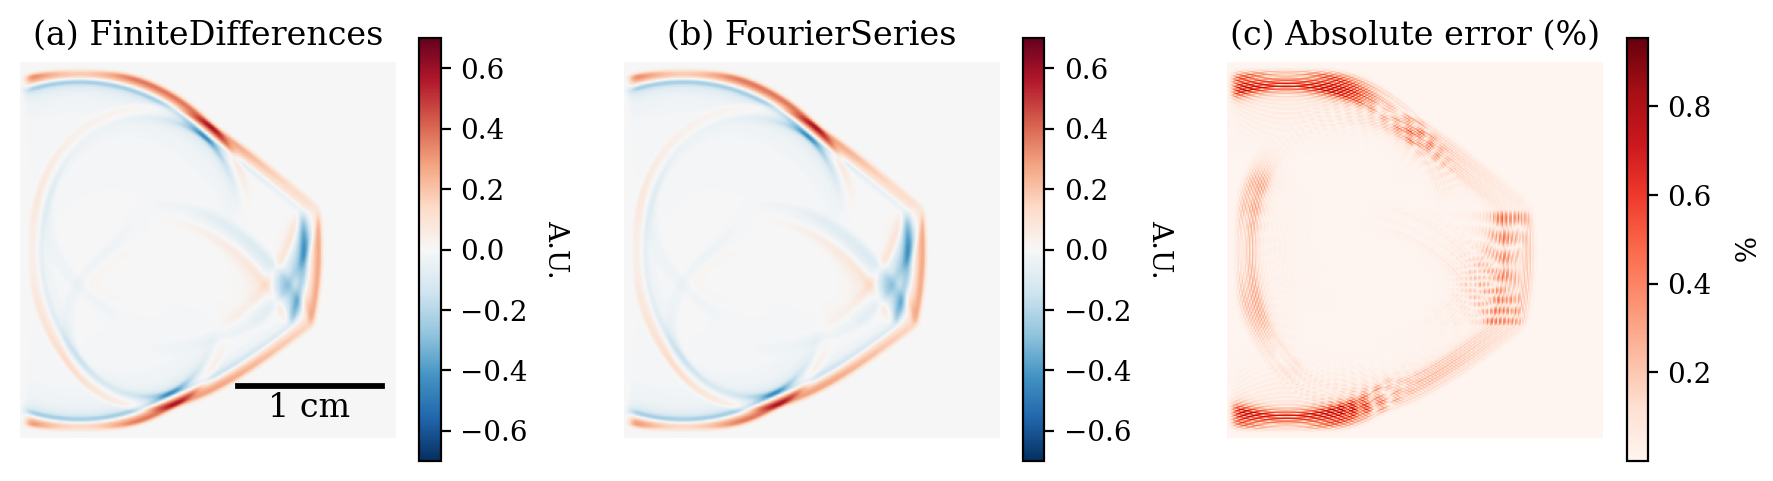

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(9,2.5), dpi=200)

im1 = ax[0].imshow(pred_fields_fd[-1].on_grid, cmap="RdBu_r", vmin=-0.7, vmax=0.7)
cbar = fig.colorbar(im1, ax=ax[0])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('A.U.', rotation=270)
ax[0].axis('off')
ax[0].set_title('(a) FiniteDifferences')

im2 = ax[1].imshow(pred_fields_fourier[-1].on_grid, cmap="RdBu_r", vmin=-0.7, vmax=0.7)
cbar = fig.colorbar(im2, ax=ax[1])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('A.U.', rotation=270)
ax[1].axis('off')
ax[1].set_title('(b) FourierSeries')

error = jnp.abs((pred_fields_fourier[-1] - pred_fields_fd[-1]).on_grid)
max_value = jnp.max(pred_fields_fourier[-1].on_grid)
error = 100*error/max_value
im_error = ax[2].imshow(error, cmap="Reds")
cbar = fig.colorbar(im_error, ax=ax[2])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('%', rotation=270)
ax[2].axis('off')
ax[2].set_title('(c) Absolute error (%)')

# Scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(
    ax[0].transData,
    100, '1 cm', 'lower right', 
    pad=0.3,
    color='black',
    frameon=False,
    size_vertical=2,
    fontproperties=fontprops)
ax[0].add_artist(scalebar)

fig.tight_layout()

plt.savefig("fourier_fd_comparison.pdf")